In [6]:
import diff_classifier.aws as aws
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import leastsq

In [2]:
filename = 'catwalk_data.csv'
folder = 'ferret_tracking'

aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name='ccurtis.data')

In [9]:
ferret_data = pd.read_csv(filename)
ferret_data = ferret_data.sort_values(by=['X'])

In [10]:
ferret_data

,,Area,Mean,Min,Max,X,Y,Perim.,Feret,Skew,FeretX,FeretY,FeretAngle,MinFeret
8,9,357,255,255,255,9.500,61.500,73.657,27.019,NaN,1,51,128.991,17.000
13,14,632,255,255,255,60.563,84.809,105.314,37.736,NaN,43,93,32.005,23.000
4,5,723,255,255,255,127.923,51.118,107.314,39.825,NaN,112,39,141.116,25.000
10,11,655,255,255,255,187.395,80.888,107.899,40.000,NaN,170,92,36.870,24.000
3,4,314,255,255,255,252.191,42.682,72.042,29.000,NaN,244,55,46.397,19.767
6,7,448,255,255,255,264.103,54.609,84.042,33.242,NaN,251,65,46.219,23.000
9,10,704,255,255,255,327.205,77.659,111.314,41.231,NaN,310,90,39.094,26.000
0,1,377,255,255,255,388.192,30.959,75.314,28.320,NaN,379,42,47.862,19.000
5,6,582,255,255,255,401.761,51.338,93.899,34.655,NaN,389,63,43.831,24.000
15,16,270,255,255,255,441.000,90.500,63.657,23.431,NaN,432,83,140.194,15.000


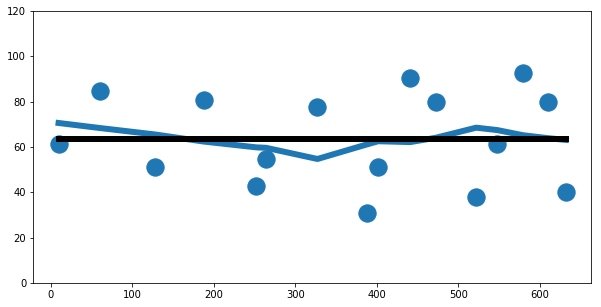

In [21]:
x = ferret_data['X']
y = ferret_data['Y']

lowess = sm.nonparametric.lowess
ymid = lowess(y, x, frac=8/16)
yavg = np.convolve(y, np.ones((16,))/16, mode='same')

plt.figure(figsize=(10, 5))
plt.scatter(x, y, s=300)
plt.plot(x, ymid[:, 1], linewidth=6)
plt.plot(x, np.mean(y)*np.ones((16,)), 'k', linewidth=6)
#plt.plot(x, yavg, 'k', linewidth=6)
plt.ylim(0, 120)
plt.show()

In [24]:
ystd = np.round(np.std(y), 2)
yrange = np.round(np.ptp(y), 2)
rsd = 100*np.round(ystd/np.mean(y), 2)

print('Deviation from midline: {}'.format(ystd))
print('Range in y: {}'.format(yrange))
print('Percent deviation from midline: {}'.format(rsd))

Deviation from midline: 19.61
Range in y: 61.54
Percent deviation from midline: 31.0
